## Задача

Выполнить сегментацию полипов согласно приложенного датасета

# Установка библиотек

In [ ]:
!pip install segmentation-models-pytorch >> None

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
from time import time

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim

from zipfile import ZipFile

from skimage.io import imread
from skimage.transform import resize

from IPython.display import clear_output

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image

import segmentation_models_pytorch as smp


зафиксируем генераторы случайных чисел для воспроизводимости обучения моделей

In [ ]:
def seed_everything(seed):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=7777)

# Скачиваем датасет

In [ ]:
with ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

images, masks = [], []
for root, _, files in os.walk(os.path.join('Kvasir-Capsule', 'images')):
    for file in files:
        img_path = os.path.join(root, file)
        mask_path = img_path.replace('images', 'masks')
        if os.path.exists(mask_path):
            images.append(imread(img_path))
            masks.append(imread(mask_path))
# images, masks = np.array(images), np.array(masks)

# Препроцессинг данных

Предобработка данных для обучения моделей сегментации на медицинских изображениях - это в том числе приведение изображений и масок к единому размеру (256×256)

Входные данные должны иметь одинаковый размер для пакетной обработки в нейросетях, anti_aliasing при изменении размера изображений улучшает визуальное качество, а для масок это не нужно, чтобы сохранить четкие границы сегментации. Бинаризация масок после ресайза гарантирует корректную разметку для обучения модели сегментации.

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

визуализируем несколько изображений и масок

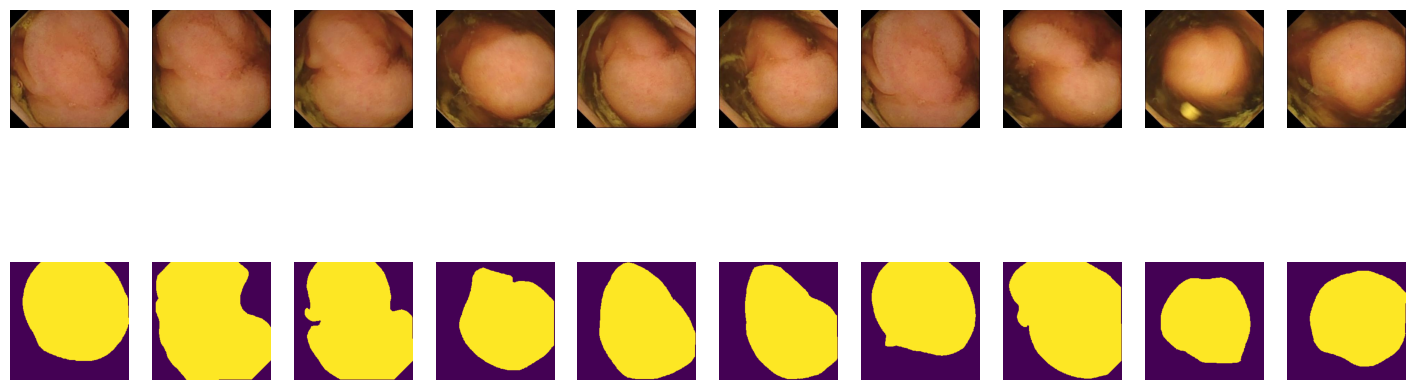

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 10, i+11)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

разделим данные случайным образом на сабсеты для обучения, валидации и тестирования моделей

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [35, 45])
len(tr), len(val), len(ts)

(35, 10, 10)

Создадим три объекта DataLoader для пакетной загрузки данных сегментации, разделенных на тренировочную, валидационную и тестовую выборки. DataLoader обеспечивают удобную и эффективную подачу данных партиями в модель PyTorch для обучения и оценки сегментации

In [ ]:
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=10, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=10, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=10, shuffle=True)

In [ ]:
# print(torch.cuda.device_count())       # число доступных GPU
# print(torch.cuda.get_device_name(0))   # имя первого GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Функции

## вычисление метрики IoU

Функция iou_pytorch реализует вычисление метрики Intersection over Union (IoU) для бинарных масок сегментации. Mетрика в обнаружении объектов, которая измеряет, насколько хорошо предсказанное ограничительное поле перекрывается с истинным ограничительным полем.Значения IoU варьируются от 0 до 1, где единица означает идеальное совпадение

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    return thresholded

## вычисление функции потерь Dice loss

Функция dice_loss реализует формулу Dice loss для задачи бинарной сегментации, которая измеряет схожесть между предсказанной маской и истинной разметкой

torch.flatten — преобразует тензоры в одномерный вектор для удобства вычислений

Dice loss определяется как 1 минус Dice коэффициент (чем меньше loss, тем лучше).

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.flatten(torch.sigmoid(y_pred))
    y_real = torch.flatten(y_real)
    num = 2 * torch.sum(y_real * y_pred)
    den =  torch.sum(y_real + y_pred)
    res = 1 - (num / den)
    return res

## вычисление функции потерь bce loss

Реализация бинарной кросс-энтропии (эквивалент BCEWithLogitsLoss)

In [ ]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred.to(device)
    y_real = y_real.to(device)
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

## обучение модели

Функция train реализует полный цикл обучения модели сегментации с валидацией и визуализацией результатов после каждой эпохи.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    device = next(model.parameters()).device
    X_val, Y_val = next(iter(data_val))

    train_losses = []
    test_losses = []
    scores = []

    for epoch in range(epochs):
        tic = time()
        print(f'* Epoch {epoch+1}/{epochs}')

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            avg_loss += loss.item() / len(data_tr)

        train_losses.append(avg_loss)

        toc = time()
        print(f'loss: {avg_loss:.6f} - time: {toc - tic:.2f}s')

        model.eval()
        with torch.no_grad():
            Y_pred = model(X_val.to(device))
            Y_pred_cpu = Y_pred.detach().cpu()
            Y_hat = torch.sigmoid(Y_pred_cpu)

            test_loss = loss_fn(Y_pred, Y_val.to(device)).item()
            test_losses.append(test_loss)

            scores.append(score_model(model, iou_pytorch, data_val))

        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        batch_size = min(6, X_val.size(0))
        for k in range(batch_size):
            # Изображение: преобразуем (C,H,W) в (H,W,C)
            img = X_val[k].cpu().numpy()
            if img.shape[0] == 1:
                img = img.squeeze(0)  # для одноканальных изображений
                plt.subplot(3, batch_size, k + 1)
                plt.imshow(img, cmap='gray')
            else:
                img = np.transpose(img, (1, 2, 0))
                plt.subplot(3, batch_size, k + 1)
                plt.imshow(img)
            plt.title('Image')
            plt.axis('off')

            # Реальная маска (ground truth)
            mask = Y_val[k].cpu().numpy()
            if mask.shape[0] == 1:
                mask = mask.squeeze(0)
            plt.subplot(3, batch_size, k + 1 + batch_size)
            plt.imshow(mask, cmap='gray')
            plt.title('Truth Mask')
            plt.axis('off')

            # Предсказанная маска
            pred_mask = Y_hat[k, 0].numpy()
            plt.subplot(3, batch_size, k + 1 + 2*batch_size)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

        plt.suptitle(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Val Loss: {test_loss:.4f}')
        plt.show()

    return train_losses, test_losses, scores


## вычисление метрики качества сегментации

Функция score_model переводит модель в режим eval(), проходит по всем батчам, получает предсказания модели, применяет сигмоид и порог, вычисляет метрику и возвращает среднее значение метрики по всему датасету.

Полученное значение позволит оценить, насколько хорошо модель сегментирует объекты на валидационном датасете

In [ ]:
def score_model(model, metric, data, threshold=0.5):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = torch.sigmoid(model(X_batch)) > threshold
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## визуализация обучения модели

In [ ]:
def plot(losses_train, losses_val, scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in losses_train], label="train_loss")
    ax1.plot([x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x for x in losses_val], label="val_loss")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Losses')

    ax2.plot(scores, label="score")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Score')

    plt.show()

    score_max = max(scores)
    print(f'Максимальный score на валидационной выборке: {score_max}')
    return score_max

структура для аккумулирования и сравнения результатов разных моделей и функций потерь в едином табличном формате

In [ ]:
df_results = pd.DataFrame(columns=['model', 'loss_function', 'score'])

# SegNet

Архитектура SegNet — сверточная сети с энкодером-декодером для сегментации

Энкодер состоит из нескольких блоков сверток с BatchNorm и ReLU, после каждого из которых идёт max-pooling с сохранением индексов (return_indices=True). Индексы пулинга используются для точного восстановления пространственной структуры при upsampling.

bottleneck — блок из двух сверточных слоев с BatchNorm и ReLU, который служит «узким местом» сети для извлечения высокоуровневых признаков.

Декодер использует MaxUnpool2d с сохранёнными индексами пулинга для восстановления пространственного разрешения, после чего применяются последовательные транспонированные свертки (ConvTranspose2d) с BatchNorm и ReLU.

Последний слой декодера выводит один канал (для бинарной сегментации).

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(inplace=True))

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2,2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU())
        self.upsample1 = nn.MaxUnpool2d(2,2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU())
        self.upsample2 = nn.MaxUnpool2d(2,2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU())
        self.upsample3 = nn.MaxUnpool2d(2,2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
                                      nn.BatchNorm2d(1),
                                      nn.ReLU())



    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, indices0 = self.pool0(e0)

        e1 = self.enc_conv1(e0)
        e1, indices1 = self.pool1(e1)

        e2 = self.enc_conv2(e1)
        e2, indices2 = self.pool2(e2)

        e3 = self.enc_conv3(e2)
        e3, indices3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder

        d0 = self.upsample0(b, indices3)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0, indices2)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1, indices1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2, indices0)
        d3 = self.dec_conv3(d3)

        return d3

## SegNet с функцией потерь bce

модель SegNet с функцией потерь бинарной кросс-энтропии (BCE) и оптимизатором Adam

In [ ]:
model_bce = SegNet().to(device)
optim = torch.optim.Adam(model_bce.parameters(), lr=0.001)

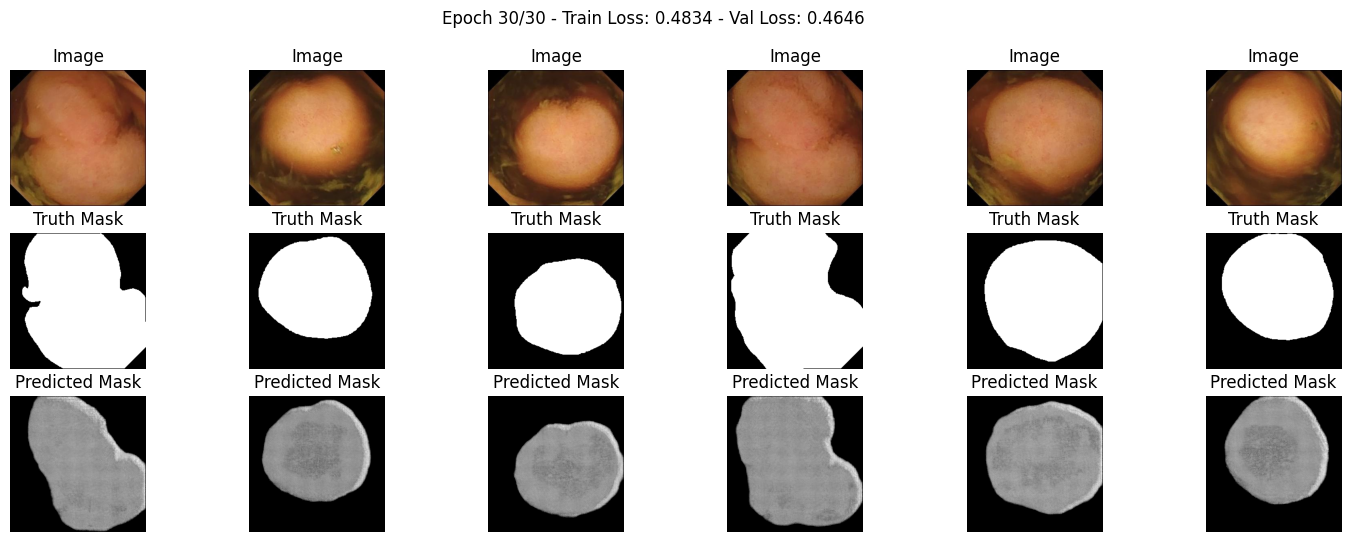

In [ ]:
max_epochs = 30
losses_train_segnet_bce, losses_val_segnet_bce, scores_segnet_bce = train(model_bce, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_bce, iou_pytorch, data_val)

0.4500000476837158

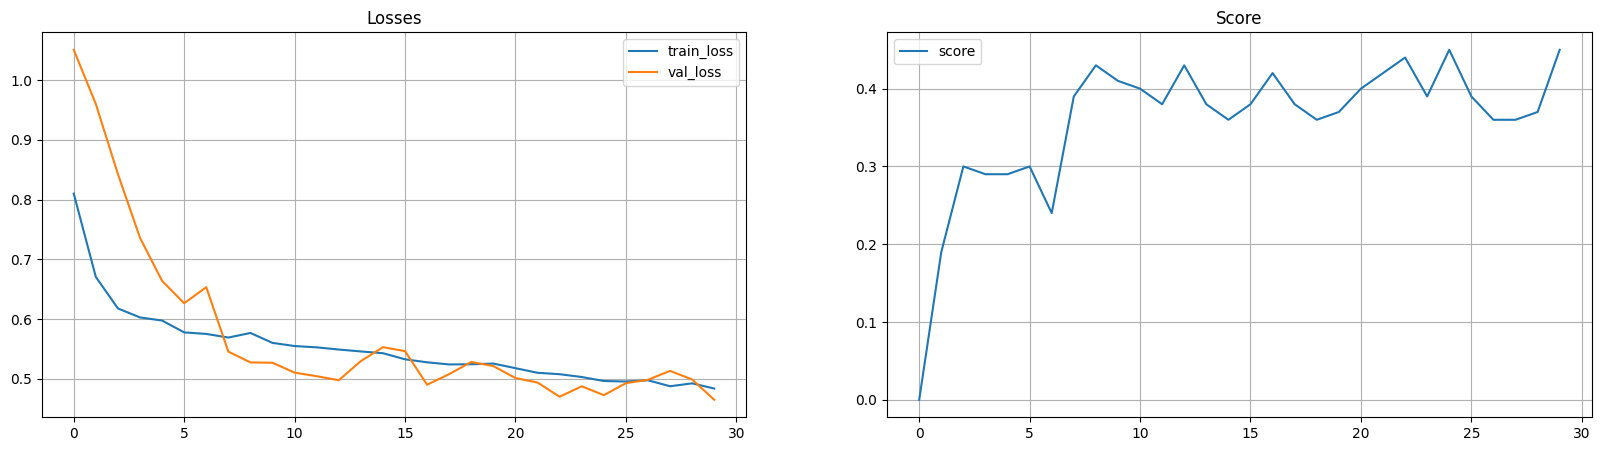

Максимальный score на валидационной выборке: 0.44999998807907104


In [ ]:
max_score_val = plot(losses_train_segnet_bce, losses_val_segnet_bce, scores_segnet_bce)

Полученное значение IoU = 0,45 не впечатляет, loss уменьшался, но тоже не особо эффективно.

In [ ]:
print("Train losses:", losses_train_segnet_bce[:6])
print("Val losses:", losses_val_segnet_bce[:6])
print("Scores:", scores_segnet_bce[:6])

Train losses: [0.8099516332149506, 0.6703772246837616, 0.6176618486642838, 0.6025527864694595, 0.5973685830831528, 0.577468067407608]
Val losses: [1.050927758216858, 0.9600480794906616, 0.8426806330680847, 0.7359088063240051, 0.6637469530105591, 0.6263466477394104]
Scores: [0.0, 0.1900000125169754, 0.30000001192092896, 0.28999999165534973, 0.2900000214576721, 0.30000001192092896]


In [ ]:
df_results = pd.concat([pd.DataFrame([['SegNet', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

<ipython-input-26-07a829b75ca7>:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([pd.DataFrame([['SegNet', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)


,model,loss_function,score
0,SegNet,bce_loss,0.45


## SegNet с функцией потерь dice

модель SegNet с функцией потерь dice и оптимизатором Adam

In [ ]:
model_dice = SegNet().to(device)
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=0.01)

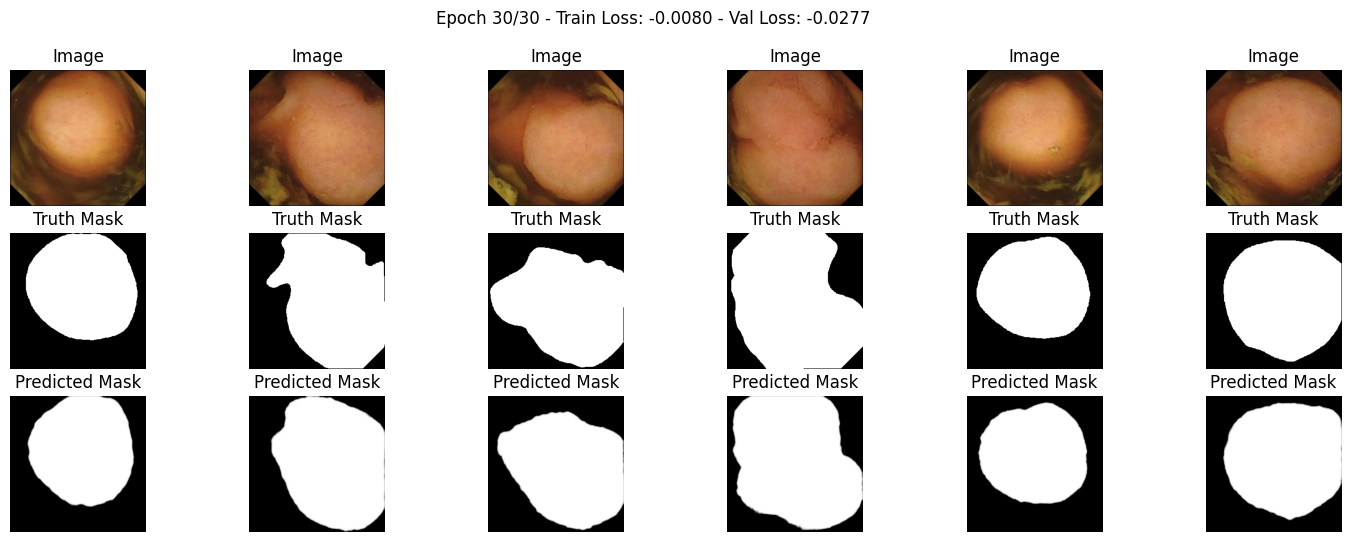

In [ ]:
max_epochs = 30
losses_train_segnet_dice, losses_val_segnet_dice, scores_segnet_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.8600000143051147

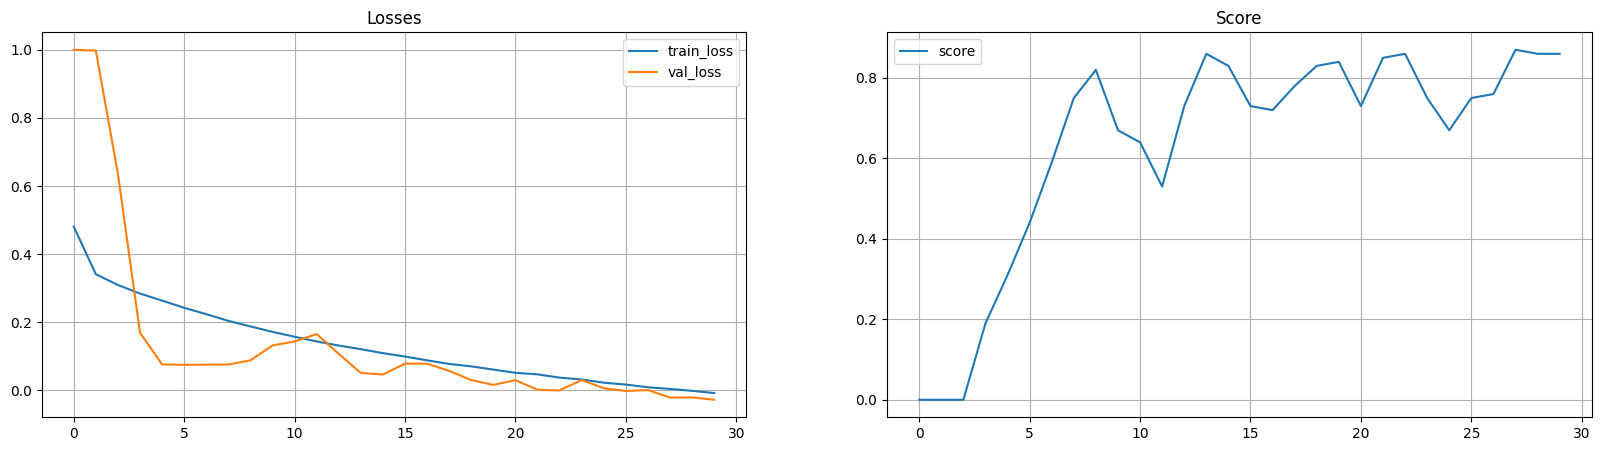

Максимальный score на валидационной выборке: 0.8700000047683716


In [ ]:
max_score_val = plot(losses_train_segnet_dice, losses_val_segnet_dice, scores_segnet_dice)

модель показывает хороший результат, но возможно, она переобучается, хотя примерно на 25 эпохе метрика и потери стабилизируются

In [ ]:
df_results = pd.concat([pd.DataFrame([['SegNet', 'dice_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

,model,loss_function,score
0,SegNet,dice_loss,0.87
1,SegNet,bce_loss,0.45


# U-net

блок из двух последовательных сверточных слоев с нормализацией и активацией ReLU, часто используемый в архитектурах типа U-Net и других сверточных сетях для сегментации и классификации изображений.Блок double convolution широко используется в архитектуре U-Net и её вариациях для сегментации

In [ ]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),)
  return conv

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = double_conv(3, 32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = double_conv(32, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = double_conv(256, 512)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = double_conv(512+256, 256)
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = double_conv(256+128, 128)
        self.upsample2 = nn.Upsample(128) # 64 -> 128
        self.dec_conv2 = double_conv(128+64, 64)
        self.upsample3 = nn.Upsample(256) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                              nn.Conv2d(in_channels=64 + 32, out_channels=32, kernel_size=3, padding=1),
                              nn.BatchNorm2d(32),
                              # # nn.ReLU(inplace=True),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
                              )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

## Unet с функцией потерь bce

In [ ]:
unet_bce = UNet().to(device)
optimizer = torch.optim.Adam(unet_bce.parameters(), lr=0.001)

применим встроенную функцию потерь torch.nn.BCEWithLogitsLoss для численной стабильности

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()

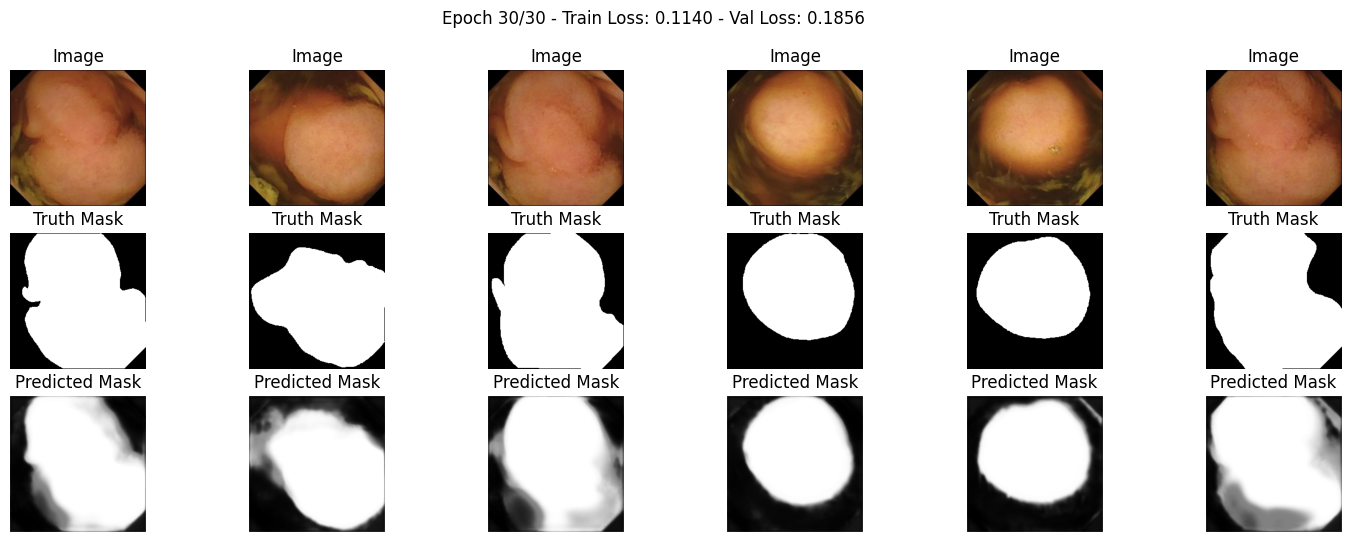

In [ ]:
max_epochs = 30
losses_train_unet_bce, losses_test_unet_bce, scores_unet_bce = train(unet_bce, optimizer, criterion, max_epochs, data_tr, data_val)

In [ ]:
# max_epochs = 30
# losses_train_unet_bce, losses_test_unet_bce, scores_unet_bce = train(unet_bce, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet_bce, iou_pytorch, data_val)

0.8300000429153442

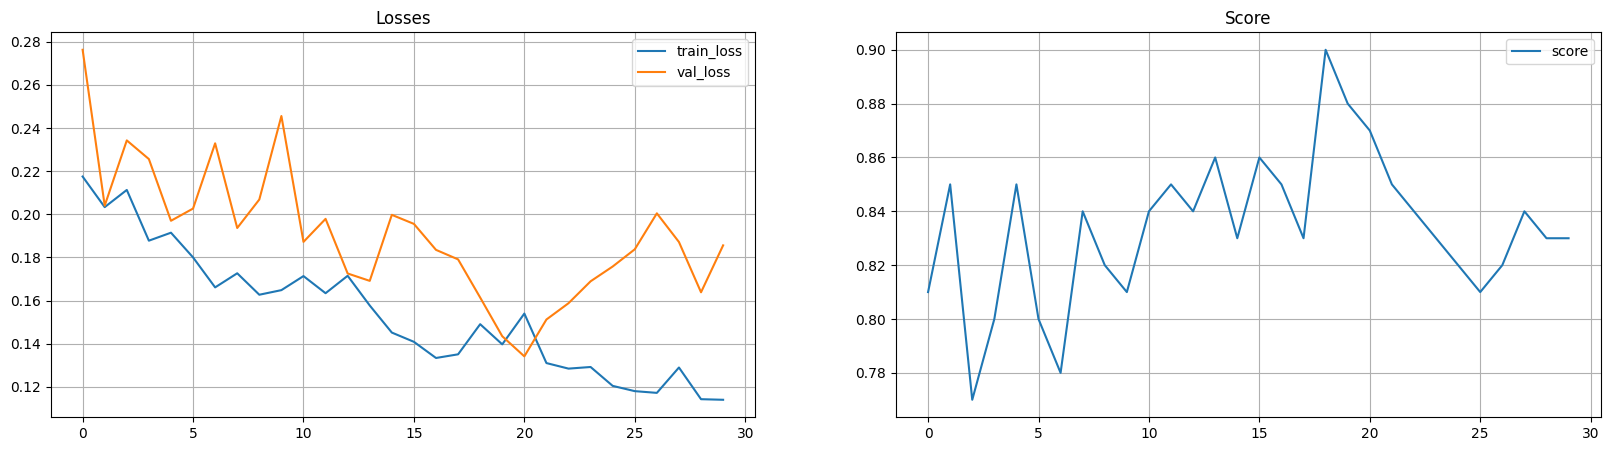

Максимальный score на валидационной выборке: 0.8999999761581421


In [ ]:
max_score_val = plot(losses_train_unet_bce, losses_test_unet_bce, scores_unet_bce)

максимальный скор 0,9??? возможно необходимо увеличить количество эпох, очень нестабильный процесс обучения

In [ ]:
df_results = pd.concat([pd.DataFrame([['Unet', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

,model,loss_function,score
0,Unet,bce_loss,0.90
1,SegNet,dice_loss,0.87
2,SegNet,bce_loss,0.45


# Аугментация

определяем трансформации

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.4),
    A.RandomRotate90(p=0.6),
    A.RandomBrightnessContrast(p=0.8),
    A.Resize(256, 256),
    ToTensorV2()
])

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask


In [ ]:
dataset = SegmentationDataset(X, Y, transform=transform)

In [ ]:
len(tr), len(val), len(ts)

(35, 10, 10)

In [ ]:
# train_length = len(tr)
# val_length = len(val)
# test_length = len(ts)

In [ ]:
dataset_length = len(dataset)
train_length = int(0.7 * dataset_length)
val_length = int(0.2 * dataset_length)
test_length = dataset_length - train_length - val_length

lengths = [train_length, val_length, test_length]
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)


In [ ]:
# lengths = [train_length, val_length, test_length]
# train_dataset, val_dataset, test_dataset = random_split(dataset, lengths)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## Unet_transfer

Используем предобученный ResNet34, загрузим веса, предобученные на ImageNet

In [ ]:
model_transfer = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,                  # Число каналов входного изображения (RGB)
    classes=1,                      # Число классов на выходе (1 для бинарной сегментации)
)

In [ ]:
model_transfer.to(device);
optimizer = torch.optim.Adam(model_transfer.parameters(), lr=0.001)

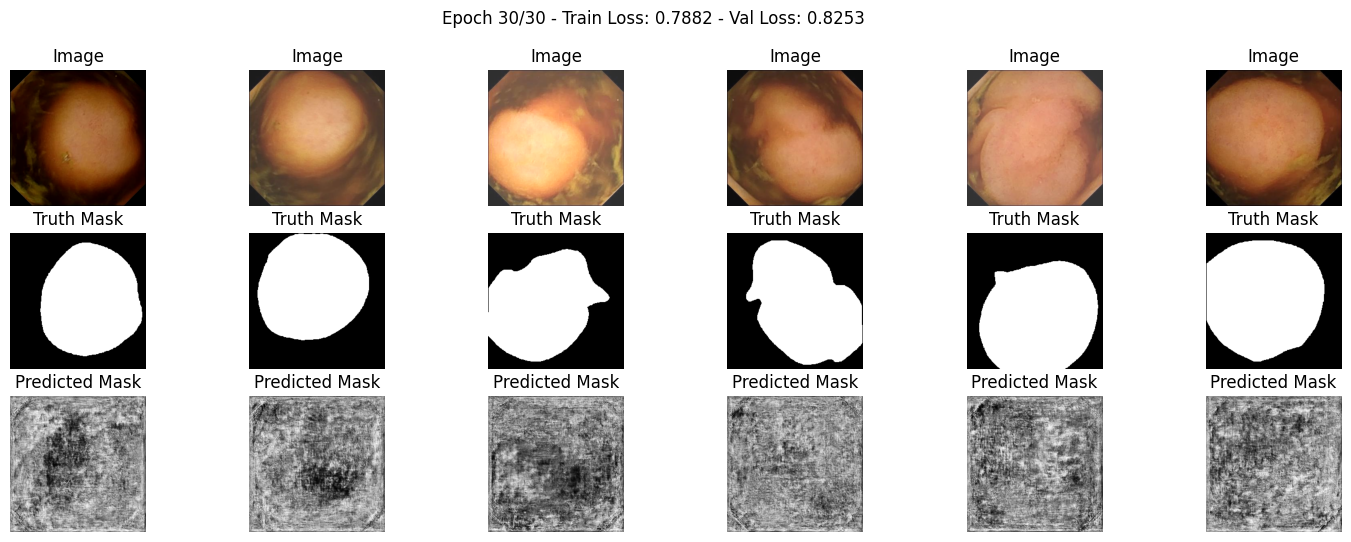

In [ ]:
max_epochs = 30
losses_train_unet_transfer, losses_test_unet_transfer_bce, scores_unet_transfer_bce = train(model_transfer, optimizer, dice_loss, max_epochs, train_loader, val_loader)

In [ ]:
score_model(model_transfer, iou_pytorch, val_loader)

0.0

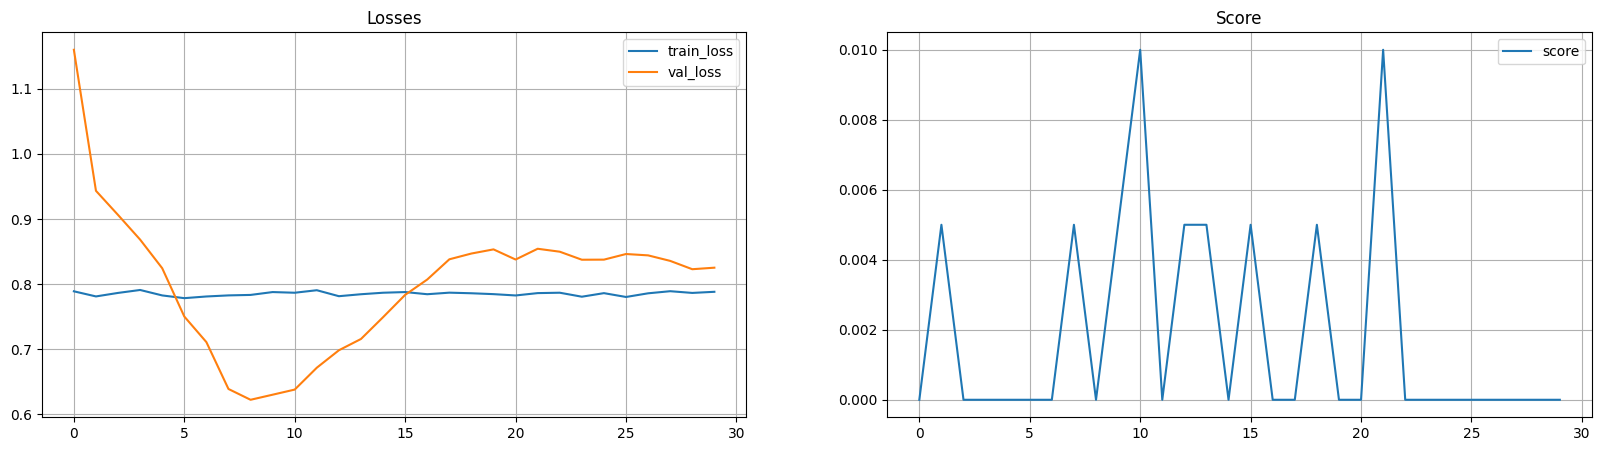

Максимальный score на валидационной выборке: 0.009999999776482582


In [ ]:
max_score_val = plot(losses_train_unet_transfer, losses_test_unet_transfer_bce, scores_unet_transfer_bce)

похоже аугментация сильно "повредила" исходные изображения??, поэтому такой плачевный результат.

In [ ]:
df_results = pd.concat([pd.DataFrame([['Unet_transfer', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

,model,loss_function,score
0,Unet_transfer,bce_loss,0.01
1,Unet,bce_loss,0.90
2,SegNet,dice_loss,0.87
3,SegNet,bce_loss,0.45


## Linknet_transfer

Используем предобученный ResNet50 на архитектуре Linknet, загрузим веса, предобученные на ImageNet

In [ ]:
model_linknet = smp.Linknet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,                  # Количество каналов входного изображения (RGB)
    classes=1,                     # Количество выходных классов (1 — бинарная сегментация)
    activation='sigmoid'           # Активация на выходе (для бинарной сегментации)
)


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
model_linknet.to(device);
optimizer = torch.optim.Adam(model_linknet.parameters(), lr=0.001)

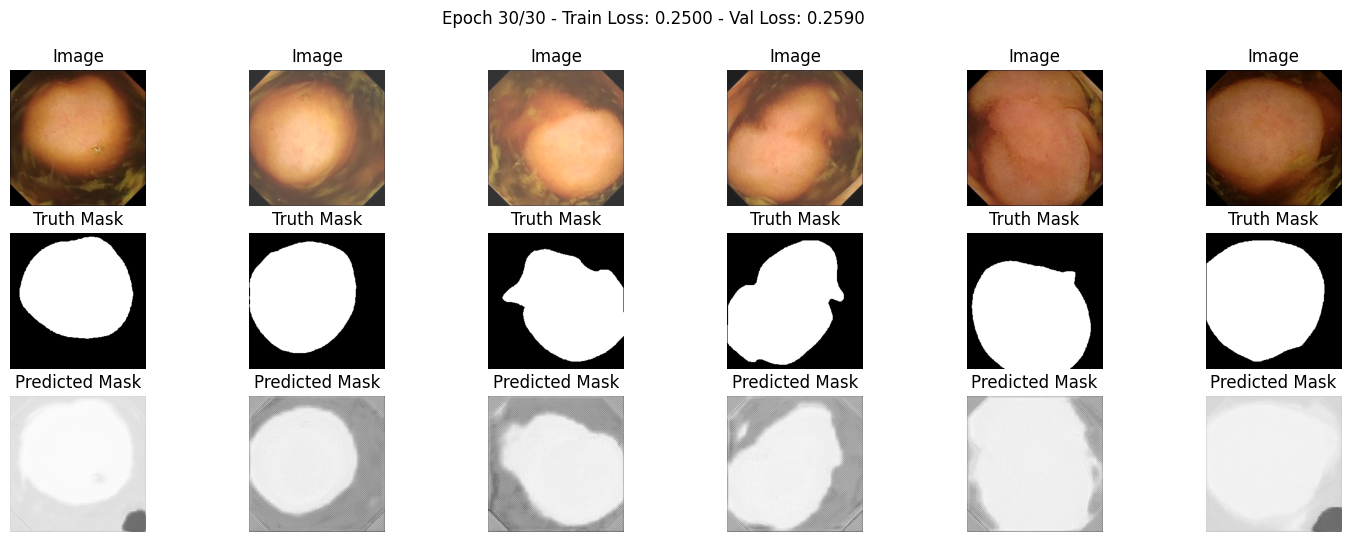

In [ ]:
max_epochs = 30
losses_train_linknet_transfer, losses_test_linknet_transfer, scores_linknet_transfer = train(model_linknet, optimizer, dice_loss, max_epochs, train_loader, val_loader)

In [ ]:
score_model(model_linknet, iou_pytorch, val_loader)

0.1900000050663948

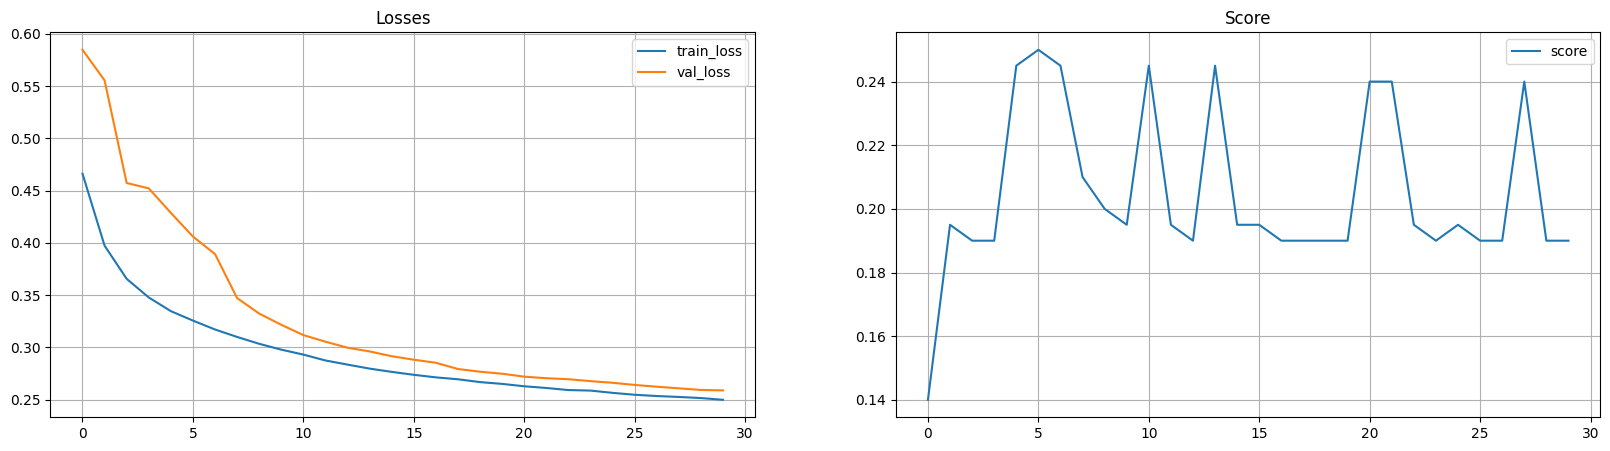

Максимальный score на валидационной выборке: 0.2500000074505806


In [ ]:
max_score_val = plot(losses_train_linknet_transfer, losses_test_linknet_transfer, scores_linknet_transfer)

тоже неэффективный результат, но хотя бы контуры пытаются прослеживаться, похоже совсем неправильное использование аугментации, но и вполне возможно неверно была выбрана предобученная модель. Но отрицательный опыт - тоже опыт.

Может быть при увеличении количества эпох обучения, результат будет улучшаться и стабилизироваться.

In [ ]:
df_results = pd.concat([pd.DataFrame([['Linknet_transfer', 'bce_loss', max_score_val]], columns=df_results.columns), df_results], ignore_index=True)
df_results

,model,loss_function,score
0,Linknet_transfer,bce_loss,0.25
1,Unet_transfer,bce_loss,0.01
2,Unet,bce_loss,0.90
3,SegNet,dice_loss,0.87
4,SegNet,bce_loss,0.45


# Предсказание

для проверки на тестовой выборке выбираем модель Segnet (loss - dice). На валидационной выборке она показала наиболее стабильный процесс и высокую метрику IoU.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def predict_and_evaluate(model, data_loader, device, threshold=0.5, save_dir=None, visualize=True):
    model.eval()
    preds = []
    truths = []
    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.cpu().numpy()
            Y_pred = model(X_batch)
            probs = torch.sigmoid(Y_pred).cpu().numpy()

            preds.append(probs)
            truths.append(Y_batch)

    preds = np.concatenate(preds, axis=0);
    truths = np.concatenate(truths, axis=0);


    # Визуализация
    if visualize:
        num_visualize = min(6, len(preds))
        plt.figure(figsize=(10, 6))
        for i in range(num_visualize):
            plt.subplot(3, num_visualize, i+1)
            img = X_batch[i].cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            plt.imshow(img)
            plt.title('Image')
            plt.axis('off')

            plt.subplot(3, num_visualize, i+1+num_visualize)
            plt.imshow(truths[i,0], cmap='gray')
            plt.title('Real Mask')
            plt.axis('off')

            plt.subplot(3, num_visualize, i+1+2*num_visualize)
            plt.imshow((preds[i,0] > threshold), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
        plt.show()


    return preds, truths

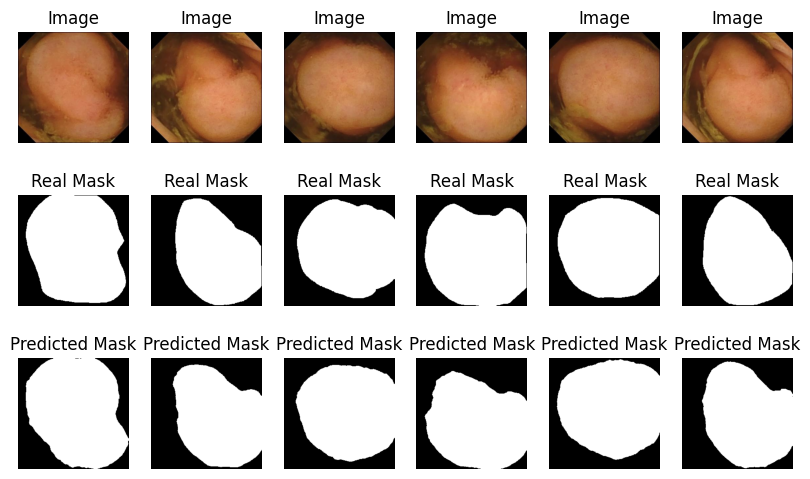

In [ ]:
predict_and_evaluate(model_dice, data_ts, device, threshold=0.5, save_dir=None, visualize=True);

In [ ]:
score_model(model_dice, iou_pytorch, data_ts)

0.8600000143051147

# Вывод

Для сегментации изображений были использованы архитектуры SegNet и Unet с функциями потерь bce и dice. Метрика оценки качества модели - Intersection over Union (IoU).

Также была применена аугментация с использованием предобученных моделей resnet. Наилучшие результаты на валидационной выборке показала модель Segnet (loss - dice). Несмотря на максимальный скор модели Unet_bce, ее не считаем лучшей по нестабильным результатам визуализации обучения.

Результаты проверки модели Segnet (loss - dice) на тестовой выборке оказались 0.86.

При тренировке других моделей возможно сказывался небольшой размер тренировочной выборки, а также надо иначе настраивать аугментацию.